In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os

In [16]:
def create_model(image_shape):
    input_img = Input(shape=image_shape)  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=image_shape)(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    encoder = Model(input_img, encoded)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
    
    return (autoencoder, encoder)

In [3]:
S = 10

In [4]:
def load_data(path='data', w=20):
    data = []
    for file in tqdm(os.listdir(path)):
        if '.jpg' in file:
            img_cv = cv2.imread(os.path.join(path, file))
            img = img_cv[:, :, ::-1]
            W = img.shape[0] // w
            H = img.shape[1] // w
            for i in range(W):
                for j in range(H):
                    data.append(img[w * i: w * (i + 1), w * j: w * (j + 1), :])
    return np.array(data)

In [10]:
all_data = load_data().astype('float32') / 255.

100%|██████████| 480/480 [00:00<00:00, 1125.44it/s]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_data, test_size=0.2)

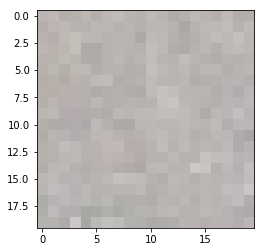

In [13]:
plt.imshow(X_train[0])

In [17]:
autoencoder, encoder = create_model((20, 20, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 8)           1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 8)           0         
__________

In [18]:
autoencoder.fit(X_train, y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, y_test))

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 18s 465us/step - loss: 0.0111 - val_loss: 0.0069
Epoch 2/50
38400/38400 [==============================] - 24s 627us/step - loss: 0.0063 - val_loss: 0.0058
Epoch 3/50
38400/38400 [==============================] - 16s 424us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 4/50
38400/38400 [==============================] - 16s 423us/step - loss: 0.0054 - val_loss: 0.0052
Epoch 5/50
38400/38400 [==============================] - 16s 424us/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/50
38400/38400 [==============================] - 16s 424us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 7/50
38400/38400 [==============================] - 16s 425us/step - loss: 0.0049 - val_loss: 0.0048
Epoch 8/50
38400/38400 [==============================] - 16s 423us/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/50
38400/38400 [==============================] - 16s 422us/step - loss: 0.0047 - val_l

In [19]:
autoencoder.save('autoencoder.h5')

In [20]:
all_data_encoder = encoder.predict(all_data)

In [21]:
all_data_encoder.shape

(48000, 3, 3, 8)

In [23]:
np.save('all_data_encoder.bin', all_data_encoder)